# TP Final

Autor: Abraham Rodriguez

Repositorio: https://github.com/AbeRodz/Time-series-II.git

## Proposito

Este proyecto consiste en utilzar datos de yahoo finance para analizar y predecir el stock de AAPL con arquitecturas de deep learning.

## A) Planteamiento de pregunta de investigacion: Plantee una pregunta que se pueda responder con su trabajo con los datos.

¿Que complejidad de modelo de deep learning puede modelar el precio de cierre considerando en recursos de computo limitados?

## B) Descripcion de los datos: Describa el origen y el tipo de dato de cada uno de los atributos de la tabla.
Datos extraidos de Yahoo finance, cuyo formato se muestra en la tabla:

$$
\begin{array}{lrrrrr}
\hline
\text{Date} & \text{Close} & \text{High} & \text{Low} & \text{Open} & \text{Volume} \\
\hline
2015\text{-}01\text{-}02 & 24.237553 & 24.705322 & 23.798602 & 24.694237 & 212818400 \\
2015\text{-}01\text{-}05 & 23.554739 & 24.086799 & 23.368519 & 24.006990 & 257142000 \\
2015\text{-}01\text{-}06 & 23.556955 & 23.816334 & 23.195597 & 23.619029 & 263188400 \\
2015\text{-}01\text{-}07 & 23.887281 & 23.987042 & 23.654504 & 23.765350 & 160423600 \\
2015\text{-}01\text{-}08 & 24.805084 & 24.862725 & 24.097887 & 24.215385 & 237458000 \\
\hline
\end{array}
$$

En este caso se utiliza la variable Close, la cual representa el precio de cierre del stock en ese dia.


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch 
from torch import nn, optim, Tensor
from torch.nn import functional as F
from torch.mps import is_available
from torch.cuda import is_available as cuda_is_available
from torch.utils.data import DataLoader,  Dataset
from trainer import Trainer

from typing import Tuple, List, Optional,Type

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [2]:
device = torch.device("mps") if is_available() else torch.device("cpu") if cuda_is_available() else torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


In [3]:
def count_parameters(model: nn.Module) -> int:
    """
    Count the number of trainable parameters in a PyTorch model.

    Args:
        model (nn.Module): The PyTorch model.

    Returns:
        int: The total number of trainable parameters.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad) / 1_000_000

In [64]:
import datetime
ticker = 'AAPL'
end_date = datetime.datetime(2025,12,5).strftime("%Y-%m-%d")
today = datetime.datetime.today().strftime("%Y-%m-%d")

data = yf.download(ticker, start="2015-01-01", end=end_date)
latest_close_data = yf.download(ticker, start=end_date, end=today)
data_close = data[['Close']]

/var/folders/bf/p7_3d4ln30l_vsv0f_41b4sw0000gn/T/ipykernel_5841/1842891338.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end=end_date)
[*********************100%***********************]  1 of 1 completed
/var/folders/bf/p7_3d4ln30l_vsv0f_41b4sw0000gn/T/ipykernel_5841/1842891338.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  latest_close_data = yf.download(ticker, start=end_date, end=today)
[*********************100%***********************]  1 of 1 completed


In [79]:
data.head(5)

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.237553,24.705322,23.798602,24.694237,212818400
2015-01-05,23.554739,24.086799,23.368519,24.006990,257142000
2015-01-06,23.556955,23.816334,23.195597,23.619029,263188400
2015-01-07,23.887281,23.987042,23.654504,23.765350,160423600
2015-01-08,24.805084,24.862725,24.097887,24.215385,237458000


In [73]:
print(data_close.isna().sum())
data_close

Price  Ticker
Close  AAPL      0
dtype: int64


Price,Close
Ticker,AAPL
Date,
2015-01-02,24.237553
2015-01-05,23.554739
2015-01-06,23.556955
2015-01-07,23.887281
2015-01-08,24.805084
...,...
2025-11-28,278.850006
2025-12-01,283.100006


In [5]:
data_close = data[("Close", "AAPL")].to_frame(name="Close")
data_close.columns = ["Close"]

In [6]:
split_date = "2025-08-30"

train_data = data_close[:split_date]
test_data  = data_close[split_date:]

In [7]:
test_data

,Close
Date,
2025-09-02,229.497528
2025-09-03,238.239059
2025-09-04,239.547775
2025-09-05,239.457870
2025-09-08,237.649628
...,...
2025-11-28,278.850006
2025-12-01,283.100006
2025-12-02,286.190002


In [8]:
scaler = MinMaxScaler()

scaled_train = scaler.fit_transform(train_data.values)
scaled_test  = scaler.transform(test_data.values)

In [9]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, dates, window_size=60):
        """
        data: scaled numpy array, shape (n_samples, 1)
        dates: datetime index aligned with 'data'
        """
        self.data = torch.tensor(data, dtype=torch.float32)
        self.dates = np.array(dates)
        self.window_size = window_size

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        x = self.data[idx : idx+self.window_size]
        y = self.data[idx+self.window_size]
        date = self.dates[idx+self.window_size].item()  # convert numpy.datetime64 -> Python datetime
        return x, y, date


In [10]:
window_size = 30

train_dataset = TimeSeriesDataset(
    scaled_train,
    train_data.index.values,
    window_size=window_size
)

test_dataset = TimeSeriesDataset(
    scaled_test,
    test_data.index.values,
    window_size=window_size
)

def collate_fn(batch):
    X = torch.stack([item[0] for item in batch])
    y = torch.stack([item[1] for item in batch])
    dates = [item[2] for item in batch]  # keep as list
    return X, y, dates

batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

# sanity check
for X_batch, y_batch, date_batch in test_loader:
    print("X shape:", X_batch.shape)
    print("y shape:", y_batch.shape)
    print("dates:", date_batch[:5])  # list of datetime.datetime objects
    break


X shape: torch.Size([32, 30, 1])
y shape: torch.Size([32, 1])
dates: [1760400000000000000, 1760486400000000000, 1760572800000000000, 1760659200000000000, 1760918400000000000]


In [11]:
train_dataset[0]

(tensor([[0.0153],
         [0.0124],
         [0.0124],
         [0.0138],
         [0.0177],
         [0.0178],
         [0.0152],
         [0.0161],
         [0.0158],
         [0.0130],
         [0.0122],
         [0.0147],
         [0.0155],
         [0.0182],
         [0.0187],
         [0.0188],
         [0.0151],
         [0.0209],
         [0.0243],
         [0.0226],
         [0.0240],
         [0.0240],
         [0.0249],
         [0.0257],
         [0.0247],
         [0.0255],
         [0.0276],
         [0.0303],
         [0.0318],
         [0.0324]]),
 tensor([0.0331]),
 1424131200000000000)

In [12]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out

In [26]:
model = LSTMModel().to(device)
m = model.compile()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
trainer = Trainer(
    model,
    train_data_loader=train_loader,
    test_data_loader=test_loader,
    loss_fn=criterion,
    gradient_accumulation_steps=8,
    optimizer=optimizer,
    scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5),
    device=device.type,
)

In [27]:
torch.cuda.empty_cache()
print("Número de parámetros: {:.5f} millones".format(count_parameters(model)))

Número de parámetros: 0.03105 millones


In [28]:
for epoch in range(20):
    print(f"Epoch {epoch+1}/10")
    trainer.train_one_epoch_time_series()

Epoch 1/10


loss 0.09096: 100%|██████████| 83/83 [00:00<00:00, 293.52it/s]


Epoch 2/10


loss 0.06891: 100%|██████████| 83/83 [00:00<00:00, 316.78it/s]


Epoch 3/10


loss 0.03373: 100%|██████████| 83/83 [00:00<00:00, 286.96it/s]


Epoch 4/10


loss 0.00813: 100%|██████████| 83/83 [00:00<00:00, 302.73it/s]


Epoch 5/10


loss 0.00561: 100%|██████████| 83/83 [00:00<00:00, 305.56it/s]


Epoch 6/10


loss 0.00397: 100%|██████████| 83/83 [00:00<00:00, 321.62it/s]


Epoch 7/10


loss 0.00280: 100%|██████████| 83/83 [00:00<00:00, 319.75it/s]


Epoch 8/10


loss 0.00299: 100%|██████████| 83/83 [00:00<00:00, 332.94it/s]


Epoch 9/10


loss 0.00216: 100%|██████████| 83/83 [00:00<00:00, 315.39it/s]


Epoch 10/10


loss 0.00249: 100%|██████████| 83/83 [00:00<00:00, 307.99it/s]


Epoch 11/10


loss 0.00237: 100%|██████████| 83/83 [00:00<00:00, 313.85it/s]


Epoch 12/10


loss 0.00232: 100%|██████████| 83/83 [00:00<00:00, 317.23it/s]


Epoch 13/10


loss 0.00260: 100%|██████████| 83/83 [00:00<00:00, 334.80it/s]


Epoch 14/10


loss 0.00184: 100%|██████████| 83/83 [00:00<00:00, 336.67it/s]


Epoch 15/10


loss 0.00196: 100%|██████████| 83/83 [00:00<00:00, 310.21it/s]


Epoch 16/10


loss 0.00194: 100%|██████████| 83/83 [00:00<00:00, 309.54it/s]


Epoch 17/10


loss 0.00212: 100%|██████████| 83/83 [00:00<00:00, 314.32it/s]


Epoch 18/10


loss 0.00199: 100%|██████████| 83/83 [00:00<00:00, 318.93it/s]


Epoch 19/10


loss 0.00190: 100%|██████████| 83/83 [00:00<00:00, 299.26it/s]


Epoch 20/10


loss 0.00167: 100%|██████████| 83/83 [00:00<00:00, 324.32it/s]


In [29]:
def evaluate_time_series(model, data_loader, device, scaler=None):
    """
    Evaluate a trained time-series model.
    Returns y_true, y_pred, metrics, and dates.
    """
    model.eval()
    y_true_list = []
    y_pred_list = []
    dates_list = []

    with torch.no_grad():
        for X_batch, y_batch, date_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            output = model(X_batch)

            y_true_list.append(y_batch.cpu())
            y_pred_list.append(output.cpu())
            dates_list.extend(date_batch)  # collect dates

    # Convert to numpy
    y_true = torch.cat(y_true_list, dim=0).numpy()
    y_pred = torch.cat(y_pred_list, dim=0).numpy()
    dates = np.array(dates_list)

    # Inverse transform if scaler provided
    if scaler is not None:
        y_true = scaler.inverse_transform(y_true)
        y_pred = scaler.inverse_transform(y_pred)

    # Compute metrics
    mse = np.mean((y_true - y_pred)**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred)/y_true)) * 100
    metrics = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

    return y_true, y_pred, metrics, dates


In [30]:
y_true, y_pred, metrics, dates = evaluate_time_series(
    model=model,
    data_loader=test_loader,
    device=device,
    scaler=scaler  
)

print(metrics)


{'MSE': np.float32(273.95792), 'RMSE': np.float32(16.551674), 'MAE': np.float32(15.608715), 'MAPE': np.float32(5.7578793)}


In [31]:
pd.DataFrame({"truth":y_true.flatten(), "pred":y_pred.flatten(), "dates":pd.to_datetime(dates)})

,truth,pred,dates
0,247.530029,245.265244,2025-10-14
1,249.098526,244.588669,2025-10-15
2,247.210358,243.988861,2025-10-16
3,252.045654,243.380951,2025-10-17
4,261.985992,243.066772,2025-10-20
5,262.515503,243.456894,2025-10-21
6,258.199707,244.259262,2025-10-22
7,259.328552,245.039383,2025-10-23
8,262.565491,245.814743,2025-10-24
9,268.549622,246.691406,2025-10-27


In [32]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

def plot_results(dates, y_true, y_pred):
    # ensure dates are datetime objects
    dates = pd.to_datetime(dates)

    plt.figure(figsize=(14,5))
    plt.plot(dates, y_true, label='Actual')
    plt.plot(dates, y_pred, label='Predicted')
    plt.title('Time Series Prediction')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()

    # improve x-axis formatting for short date ranges
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))  # tick every day
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


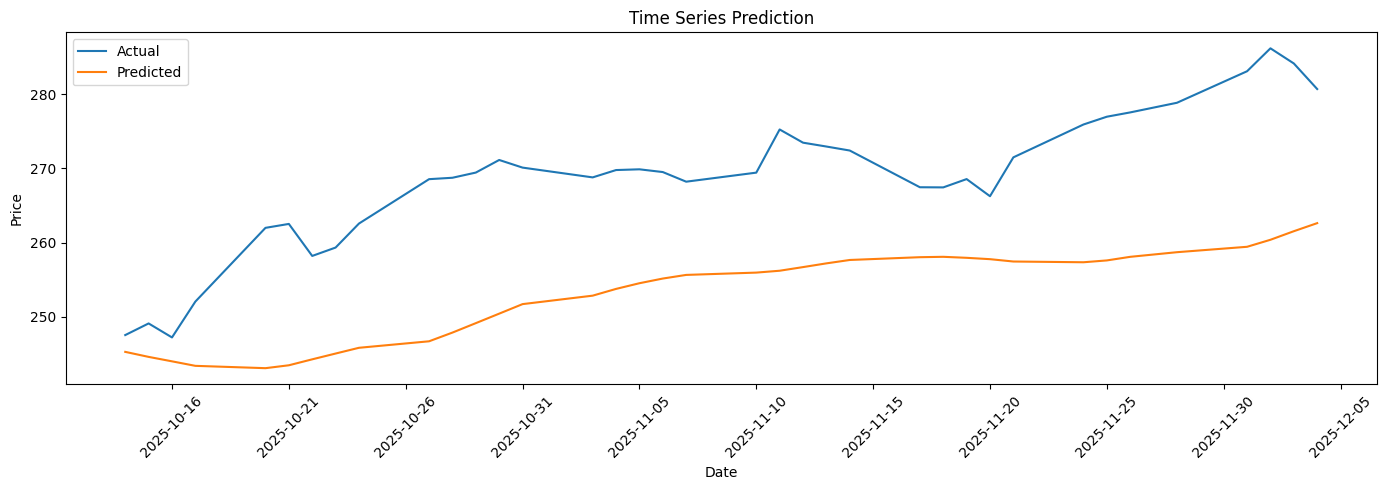

In [33]:
plot_results(dates, y_true, y_pred)

# N-Beats
Implementacion ligera de [N-Beats](https://arxiv.org/pdf/1905.10437), consiste en un modelo interpetable que hace uso de enlaces residuales y redes fully connected.

In [34]:
class NBeatsBlock(nn.Module):
    def __init__(self, input_size, hidden_size, theta_size, n_layers=4):
        super().__init__()
        layers = []
        for _ in range(n_layers):
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            input_size = hidden_size
        self.fc = nn.Sequential(*layers)
        self.theta = nn.Linear(hidden_size, theta_size)

    def forward(self, x):
        x = self.fc(x)
        theta = self.theta(x)
        return theta


class NBeats(nn.Module):
    def __init__(self, input_len, output_len, hidden_size=256, n_blocks=3):
        super().__init__()

        self.blocks = nn.ModuleList()
        for _ in range(n_blocks):
            # theta size = input + output decomposition parameters
            theta_size = input_len + output_len
            self.blocks.append(NBeatsBlock(input_len, hidden_size, theta_size))

        self.input_len = input_len
        self.output_len = output_len

    def forward(self, x):
            # x is (batch, window_size, 1)
        if x.dim() == 3:
            x = x.squeeze(-1) 
        residual = x
        forecast = 0

        for block in self.blocks:
            theta = block(residual)
            backcast = theta[:, :self.input_len]
            block_forecast = theta[:, -self.output_len:]

            residual = residual - backcast
            forecast = forecast + block_forecast

        return forecast


In [35]:
model_n_beats = NBeats(input_len=window_size, output_len=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_n_beats.parameters(), lr=1e-3)
trainer = Trainer(
    model_n_beats,
    train_data_loader=train_loader,
    test_data_loader=test_loader,
    loss_fn=criterion,
    gradient_accumulation_steps=8,
    optimizer=optimizer,
    scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5),
    device=device.type,
)

In [36]:
torch.cuda.empty_cache()
print("Número de parámetros: {:.5f} millones".format(count_parameters(model_n_beats)))

Número de parámetros: 0.63984 millones


In [37]:
for epoch in range(20):
    print(f"Epoch {epoch+1}/10")
    trainer.train_one_epoch_time_series()

Epoch 1/10


loss 0.01380: 100%|██████████| 83/83 [00:00<00:00, 261.00it/s]


Epoch 2/10


loss 0.00312: 100%|██████████| 83/83 [00:00<00:00, 255.62it/s]


Epoch 3/10


loss 0.00108: 100%|██████████| 83/83 [00:00<00:00, 288.26it/s]


Epoch 4/10


loss 0.00081: 100%|██████████| 83/83 [00:00<00:00, 252.71it/s]


Epoch 5/10


loss 0.00061: 100%|██████████| 83/83 [00:00<00:00, 252.79it/s]


Epoch 6/10


loss 0.00071: 100%|██████████| 83/83 [00:00<00:00, 294.04it/s]


Epoch 7/10


loss 0.00049: 100%|██████████| 83/83 [00:00<00:00, 295.37it/s]


Epoch 8/10


loss 0.00062: 100%|██████████| 83/83 [00:00<00:00, 265.08it/s]


Epoch 9/10


loss 0.00042: 100%|██████████| 83/83 [00:00<00:00, 287.51it/s]


Epoch 10/10


loss 0.00037: 100%|██████████| 83/83 [00:00<00:00, 270.46it/s]


Epoch 11/10


loss 0.00028: 100%|██████████| 83/83 [00:00<00:00, 291.74it/s]


Epoch 12/10


loss 0.00037: 100%|██████████| 83/83 [00:00<00:00, 292.08it/s]


Epoch 13/10


loss 0.00035: 100%|██████████| 83/83 [00:00<00:00, 299.11it/s]


Epoch 14/10


loss 0.00026: 100%|██████████| 83/83 [00:00<00:00, 301.75it/s]


Epoch 15/10


loss 0.00025: 100%|██████████| 83/83 [00:00<00:00, 278.26it/s]


Epoch 16/10


loss 0.00026: 100%|██████████| 83/83 [00:00<00:00, 276.61it/s]


Epoch 17/10


loss 0.00017: 100%|██████████| 83/83 [00:00<00:00, 299.40it/s]


Epoch 18/10


loss 0.00031: 100%|██████████| 83/83 [00:00<00:00, 303.10it/s]


Epoch 19/10


loss 0.00024: 100%|██████████| 83/83 [00:00<00:00, 301.70it/s]


Epoch 20/10


loss 0.00027: 100%|██████████| 83/83 [00:00<00:00, 297.24it/s]


In [38]:
y_true, y_pred, metrics, dates = evaluate_time_series(
    model=model_n_beats,
    data_loader=test_loader,
    device=device,
    scaler=scaler  
)

print(metrics)


{'MSE': np.float32(108.838905), 'RMSE': np.float32(10.432589), 'MAE': np.float32(9.489587), 'MAPE': np.float32(3.50412)}


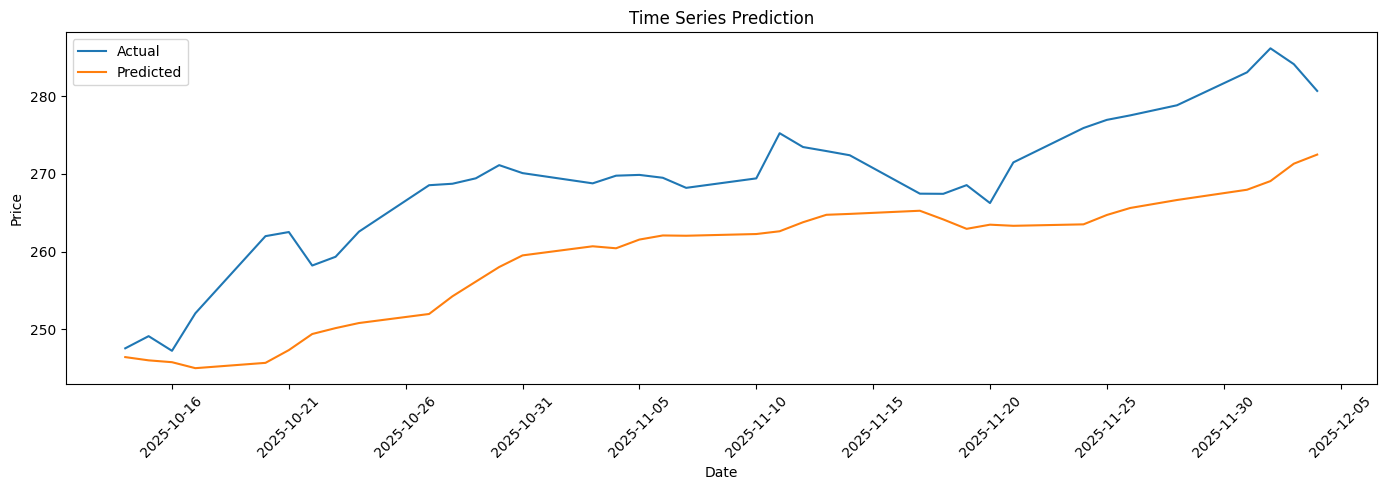

In [39]:
plot_results(dates, y_true, y_pred)

# Transfomer Decoder o GPT

Basado en investigaciones de transformer decoders y arquitecturas GPT aplicadas en tareas de series de tiempo.

- [Lag-Lllama](https://arxiv.org/pdf/2310.08278)
- [TimesFM](https://arxiv.org/pdf/2310.10688)
- [MarketGPT](https://arxiv.org/pdf/2411.16585)
- [Toto](https://arxiv.org/pdf/2407.07874)

La implementacion en este notebook consiste en un GPT ligero.

In [40]:
from dataclasses import dataclass
@dataclass
class GPTConfig:
    """
    Base class for GPT models.
    """
    block_size: int = window_size
    batch_size: int = 8
    n_embd: int = 64
    n_head: int = 4
    n_layer: int = 2
    dropout: float = 0.1
    seq_len: int = window_size
    bias: bool = True
    ff_class: Optional[Type[nn.Module]] = None

config = GPTConfig()
print(config.__dict__)

{'block_size': 30, 'batch_size': 8, 'n_embd': 64, 'n_head': 4, 'n_layer': 2, 'dropout': 0.1, 'seq_len': 30, 'bias': True, 'ff_class': None}


In [41]:
class AttentionHead(nn.Module):
    """
    Scaled Dot-Product Attention Head for Multi-Head Attention.
    """
    def __init__(self, args: GPTConfig) -> None:
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.head_dim = args.n_embd // args.n_head

        # Combined QKV projection
        self.key_query_value = nn.Linear(args.n_embd, 3 * self.head_dim, bias=args.bias)

        self.dropout = nn.Dropout(args.dropout)
        self.block_size = args.block_size
        self.register_buffer('tril', torch.tril(torch.ones(args.block_size, args.block_size)))

    def forward(self, x: torch.Tensor, kv_cache: Optional[torch.Tensor] = None, return_weights=False):
        B, T, C = x.shape
        key_query_value = self.key_query_value(x)  # (B, T, 3 * head_dim)
        k, q, v = torch.chunk(key_query_value, 3, dim=-1)  # (B, T, head_dim) each

        if kv_cache is not None:
            key_cache, value_cache = kv_cache.unbind(dim=0)  # (B, T', head_dim)
            k = torch.cat((key_cache, k), dim=1)
            v = torch.cat((value_cache, v), dim=1)

        # Scaled dot-product attention
        wei = q @ k.transpose(-2, -1) * (self.head_dim ** -0.5)  # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        out = wei @ v  # (B, T, head_dim)

        if return_weights:
            return out, wei

        if kv_cache is not None:
            return out, torch.stack((k, v))

        return out, None

In [42]:
class MultiHeadAttention(nn.Module):
    def __init__(self, args: GPTConfig):
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.n_heads = args.n_head
        self.head_dim = args.n_embd // args.n_head

        self.heads = nn.ModuleList([
            AttentionHead(args) for _ in range(self.n_heads)
        ])

        self.proj = nn.Linear(args.n_embd, args.n_embd, bias=args.bias)
        self.dropout = nn.Dropout(args.dropout)

    def forward(self, x, kv_cache=None, return_weights=False):
        all_outputs = []
        all_weights = []
        new_kv_cache = [] if kv_cache is not None else None

        for i, head in enumerate(self.heads):
            head_cache = kv_cache[i] if kv_cache is not None else None
            out, weights_or_kv = head(x, kv_cache=head_cache, return_weights=return_weights)
            all_outputs.append(out)
            if return_weights:
                all_weights.append(weights_or_kv)
            if kv_cache is not None:
                new_kv_cache.append(weights_or_kv)  # weights_or_kv is new kv_cache here

        concat = torch.cat(all_outputs, dim=-1)  # concat along embedding dim
        out = self.dropout(self.proj(concat))

        if return_weights:
            return out, torch.stack(all_weights)
        if kv_cache is not None:
            return out, new_kv_cache
        return out

In [43]:
class FeedForward(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = MultiHeadAttention(config)

        ff_class = config.ff_class if config.ff_class is not None else FeedForward
        self.ff = ff_class(config)

    def forward(self, x, kv_cache=None, return_weights=False):
        attn_out = self.attn(self.ln1(x), kv_cache=kv_cache, return_weights=return_weights)
        if return_weights:
            attn_out, weights = attn_out
        else:
            weights = None

        if isinstance(attn_out, tuple):
            attn_out, updated_kv = attn_out
        else:
            updated_kv = None

        x = x + attn_out
        x = x + self.ff(self.ln2(x))

        if return_weights:
            return x, updated_kv, weights
        else:
            return x  


In [44]:
class TimeSeriesGPT(nn.Module):
    def __init__(self, block, config: GPTConfig, feature_size=1 ):
        super().__init__()
        self.seq_len = config.seq_len
        self.feature_proj = nn.Linear(feature_size, config.n_embd)
        self.pos_emb = nn.Parameter(torch.zeros(1, config.seq_len, config.n_embd))
        self.blocks = nn.Sequential(*[block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, 1)

    def forward(self, x):
        x = self.feature_proj(x) + self.pos_emb[:, :x.size(1), :]
        x = self.blocks(x)
        x = self.ln_f(x)
        return self.head(x[:, -1, :])

In [45]:
config.n_layer = 2
config.batch_size = batch_size
config.n_embd = 64
config.n_head = 4
config.bias = False
config.dropout = 0.2

In [46]:
gpt = TimeSeriesGPT(Block, config=config).to(device)

In [47]:
torch.cuda.empty_cache()
print("Número de parámetros: {:.5f} millones".format(count_parameters(gpt)))

Número de parámetros: 0.10170 millones


In [48]:
config

GPTConfig(block_size=30, batch_size=32, n_embd=64, n_head=4, n_layer=2, dropout=0.2, seq_len=30, bias=False, ff_class=None)

In [49]:
assert config.n_embd % config.n_head == 0

In [50]:
criterion = nn.MSELoss()
optimizer = optim.AdamW(gpt.parameters(), lr=1e-3)
gpt_trainer = Trainer(
    gpt,
    train_data_loader=train_loader,
    test_data_loader=test_loader,
    loss_fn=criterion,
    gradient_accumulation_steps=8,
    optimizer=optimizer,
    scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5),
    device=device.type,
)

In [51]:
for epoch in range(20):  
    avg_train_loss = gpt_trainer.train_one_epoch_time_series()
    print(f"Epoch {epoch+1} training loss: {avg_train_loss:.4f}")


loss 0.08882: 100%|██████████| 83/83 [00:00<00:00, 103.43it/s]


Epoch 1 training loss: 0.0956


loss 0.01366: 100%|██████████| 83/83 [00:00<00:00, 128.69it/s]


Epoch 2 training loss: 0.0120


loss 0.01016: 100%|██████████| 83/83 [00:00<00:00, 139.34it/s]


Epoch 3 training loss: 0.0094


loss 0.00393: 100%|██████████| 83/83 [00:00<00:00, 137.51it/s]


Epoch 4 training loss: 0.0036


loss 0.00280: 100%|██████████| 83/83 [00:00<00:00, 137.31it/s]


Epoch 5 training loss: 0.0029


loss 0.00229: 100%|██████████| 83/83 [00:00<00:00, 126.13it/s]


Epoch 6 training loss: 0.0022


loss 0.00137: 100%|██████████| 83/83 [00:00<00:00, 123.58it/s]


Epoch 7 training loss: 0.0014


loss 0.00154: 100%|██████████| 83/83 [00:00<00:00, 135.12it/s]


Epoch 8 training loss: 0.0015


loss 0.00131: 100%|██████████| 83/83 [00:00<00:00, 137.84it/s]


Epoch 9 training loss: 0.0012


loss 0.00111: 100%|██████████| 83/83 [00:00<00:00, 142.07it/s]


Epoch 10 training loss: 0.0011


loss 0.00114: 100%|██████████| 83/83 [00:00<00:00, 131.99it/s]


Epoch 11 training loss: 0.0010


loss 0.00100: 100%|██████████| 83/83 [00:00<00:00, 125.12it/s]


Epoch 12 training loss: 0.0011


loss 0.00081: 100%|██████████| 83/83 [00:00<00:00, 137.76it/s]


Epoch 13 training loss: 0.0008


loss 0.00067: 100%|██████████| 83/83 [00:00<00:00, 131.72it/s]


Epoch 14 training loss: 0.0007


loss 0.00081: 100%|██████████| 83/83 [00:00<00:00, 145.44it/s]


Epoch 15 training loss: 0.0009


loss 0.00077: 100%|██████████| 83/83 [00:00<00:00, 136.70it/s]


Epoch 16 training loss: 0.0007


loss 0.00111: 100%|██████████| 83/83 [00:00<00:00, 136.92it/s]


Epoch 17 training loss: 0.0010


loss 0.00083: 100%|██████████| 83/83 [00:00<00:00, 116.91it/s]


Epoch 18 training loss: 0.0008


loss 0.00084: 100%|██████████| 83/83 [00:00<00:00, 135.68it/s]


Epoch 19 training loss: 0.0007


loss 0.00064: 100%|██████████| 83/83 [00:00<00:00, 142.91it/s]

Epoch 20 training loss: 0.0007


In [52]:
y_true, y_pred, metrics, dates = evaluate_time_series(
    model=gpt,
    data_loader=test_loader,
    device=device,
    scaler=scaler  
)

print(metrics)


{'MSE': np.float32(17.936575), 'RMSE': np.float32(4.2351594), 'MAE': np.float32(3.5977376), 'MAPE': np.float32(1.3282889)}


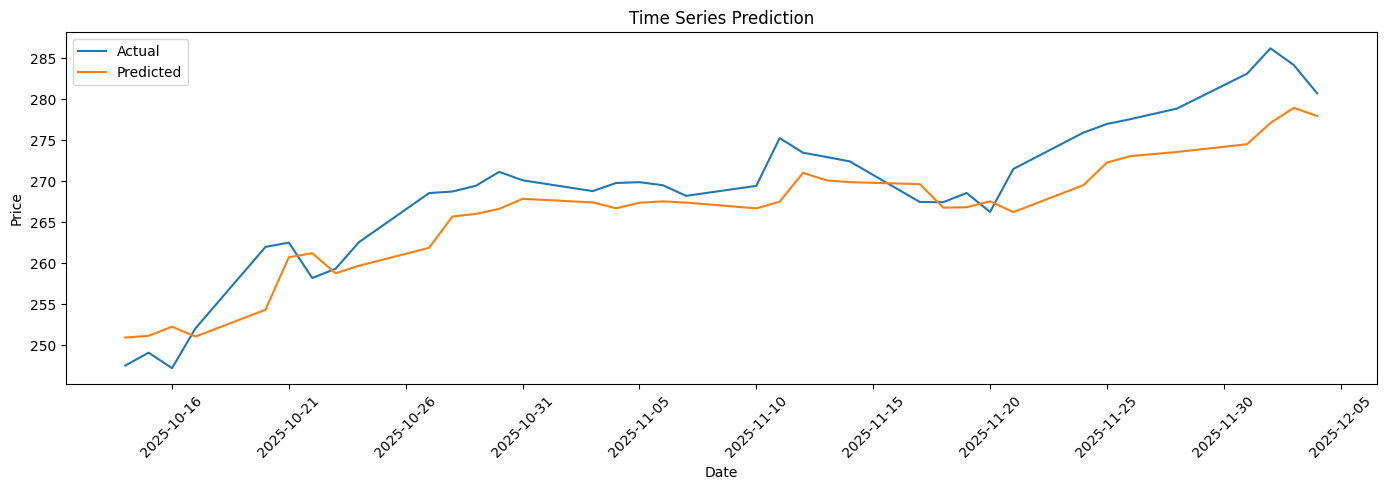

In [53]:
plot_results(dates, y_true, y_pred)

In [54]:
pd.DataFrame({"truth":y_true.flatten(), "pred":y_pred.flatten(), "dates":pd.to_datetime(dates)})

,truth,pred,dates
0,247.530029,250.944290,2025-10-14
1,249.098526,251.153656,2025-10-15
2,247.210358,252.271240,2025-10-16
3,252.045654,251.055634,2025-10-17
4,261.985992,254.330215,2025-10-20
5,262.515503,260.725525,2025-10-21
6,258.199707,261.224457,2025-10-22
7,259.328552,258.779053,2025-10-23
8,262.565491,259.690338,2025-10-24
9,268.549622,261.878387,2025-10-27


In [55]:
def forecast_future(model, last_window, steps, scaler=None, device="mps"):
    """
    last_window: numpy array of shape (window_size, 1) scaled!
    steps: how many future predictions to generate
    """
    model.eval()
    window = torch.tensor(last_window, dtype=torch.float32).unsqueeze(0).to(device)
    preds = []

    for _ in range(steps):
        with torch.no_grad():
            next_pred = model(window).cpu().numpy()

        preds.append(next_pred[0])

        # Update rolling window
        next_scaled = torch.tensor(next_pred, dtype=torch.float32).unsqueeze(0)
        window = torch.cat([window[:, 1:, :], next_scaled.to(device)], dim=1)

    preds = np.array(preds)

    # Inverse scale
    if scaler is not None:
        preds = scaler.inverse_transform(preds)

    return preds


In [56]:
last_window = scaled_test[-window_size:]

In [58]:
future_lstm = forecast_future(
    model=model,
    last_window=last_window,
    steps=30,
    scaler=scaler,
    device=device
)

future_n_beats = forecast_future(
    model=model_n_beats,
    last_window=last_window,
    steps=30,
    scaler=scaler,
    device=device
)

future_gpt = forecast_future(
    model=gpt,
    last_window=last_window,
    steps=30,
    scaler=scaler,
    device=device
)


In [65]:
latest_close_data

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-12-05,278.779999,281.140015,278.049988,280.540009,47265800
2025-12-08,277.890015,279.670013,276.149994,278.130005,38211800
2025-12-09,277.179993,280.029999,276.920013,278.160004,32193300


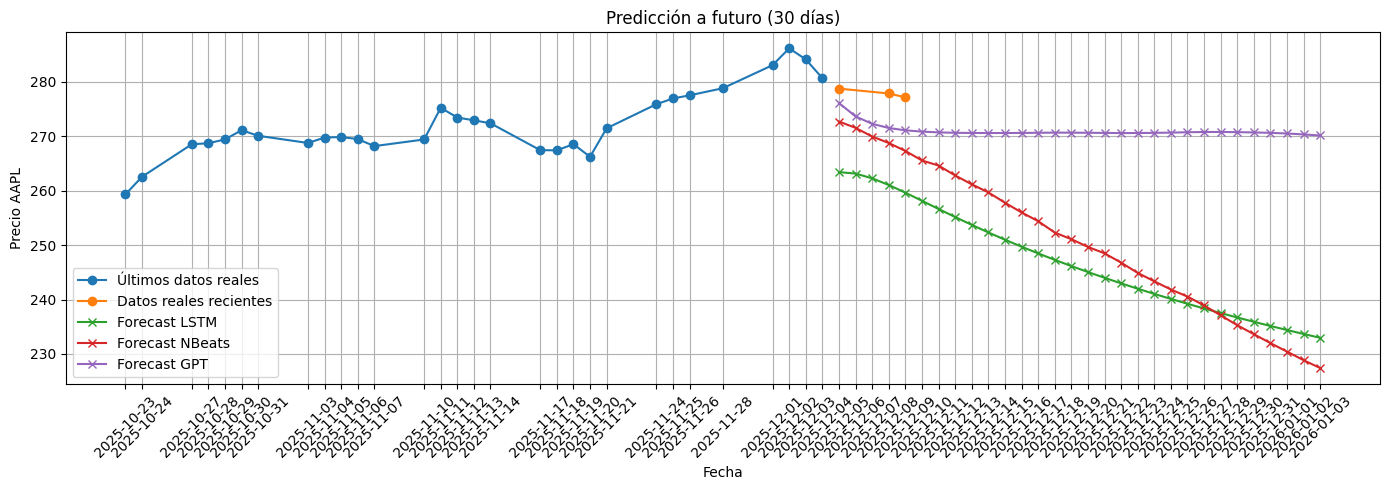

In [66]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Include the last real day in the past data
past = data_close[-window_size:].copy()

# Last real date
last_real_date = past.index[-1]

# Generate future dates starting from the day after the last real date
future_dates = pd.date_range(start=last_real_date + pd.Timedelta(days=1), periods=len(future_lstm), freq="D")

plt.figure(figsize=(14,5))

# Plot past real data
plt.plot(past.index, past.values, label="Últimos datos reales", marker='o')
plt.plot(latest_close_data.index, latest_close_data['Close'].values, label="Datos reales recientes", marker='o')

# Plot forecasts
plt.plot(future_dates, future_lstm, label="Forecast LSTM", marker='x')
plt.plot(future_dates, future_n_beats, label="Forecast NBeats", marker='x')
plt.plot(future_dates, future_gpt, label="Forecast GPT", marker='x')

plt.title("Predicción a futuro (30 días)")
plt.xlabel("Fecha")
plt.ylabel("Precio AAPL")
plt.legend()
plt.grid(True)

# Set every day as a tick for clarity
all_dates = past.index.append(future_dates)
plt.xticks(all_dates, rotation=45)

# Format dates nicely
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.tight_layout()
plt.show()
